Simulation of moving bar with two cell types and delayed feedback
July 28, 2020 created by CKC
based on NF_MB_02 but with a smooth moving bar by using a stimulation with continuous position

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
def K(x,s):
    return(np.exp(-(x/s)**2))

In [3]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [4]:
klen = 80
hw = 10
xx = np.arange(klen)

sigma_c = 30
sigma_h = 40

kcxs = K(xx,sigma_c)
khxs = K(xx,sigma_h)
KH = np.zeros(klen*2-1)
KC = np.zeros(klen*2-1)
tmp = khxs[::-1]
KH[0:klen]= tmp[0:klen]
KH[klen:2*klen]=khxs[1:klen]

tmp = kcxs[::-1]
KC[0:klen]= tmp[0:klen]
KC[klen:2*klen]=kcxs[1:klen]
CS=KC-0.3*KH

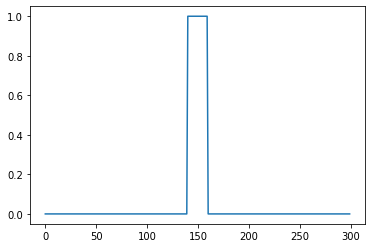

In [5]:
xlen = 300 #spatial extend of simulation
i0 = 150
s = np.zeros(xlen)
s[i0-hw:i0+hw] = 1
plt.plot(s)

In [6]:
# Guassian function with mean x0 and standard deviation sigma
def G(x,x0,sigma):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = np.exp(-((x[i]-x0)/sigma)**2)
    return(y)

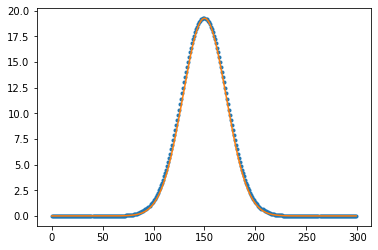

In [7]:
# macthing with Gussian profile with convoluted result
r = np.convolve(s,KC,'same')
altitude = max(r)
tempx = np.arange(xlen)
plt.plot(r,'.')

#Do some optimization, find best sigma ratio
distances = []
ratios = np.arange(1,50)*0.1
for ratio in ratios:
    temp_y = altitude*G(tempx,i0,sigma_c*ratio)
    distance = np.linalg.norm(temp_y-r)
    distances.append(distance)
distances = np.array(distances)
min_index = np.where(distances==min(distances))
tempy = altitude*G(tempx,i0,sigma_c*ratios[min_index]) # this form will be used for stimulation
plt.plot(tempy)

In [8]:
#main
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
# HMM ; input
Gamma=4.5
Omega =Gamma/2.12
D = 27*10**5
HMM=np.zeros(len(T))
vL =np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1]=HMM[i]+vL[i]*dt
    vL[i+1]=vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

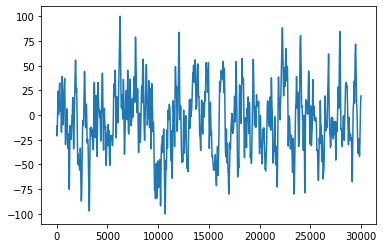

In [9]:
x = (LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*200-100
plt.plot(x)

In [10]:
dt = 0.01

alpha = 80
beta = 2

k = 400
g = 1/20

pos_0 = 150
nstep = 10000
v = 10 # moving bar velocity
#v = 0

y = np.zeros(xlen) # cone cell output
z = np.zeros(xlen) # horizontal cell output


speak = np.zeros(nstep)
rpeak = np.zeros(nstep)

stm = []
rsp = []
zts = []
tmp = []

for i in range(nstep):
    #s = np.zeros(xlen)            # stimulation array
    #d = int(v*i)                  # distance travelled by the moving bar
    #speak[i]= i0+d                # peak position of stimulatino
    #s[i0+d-hw:i0+hw+d] = 1        # stimualation turned on for the bar position
    #rs = np.convolve(s,KC,'same') # stimulation (s) convoluted with cone receptive field KC
    pos = pos_0+x[i]
    speak[i] = pos
    rs =  altitude*G(tempx,pos,sigma_c*ratios[min_index])
    ry = np.convolve(y,KH,'same') # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    
    for j in range(xlen):
        dyj =(-alpha*y[j]+k*(rs[j]-z[j]))*dt
        dzj =(-beta*z[j]+g*ry[j])*dt
        y[j] = y[j]+dyj
        z[j] = z[j]+dzj
    maxpos = np.argmax(y)
    rpeak[i]= maxpos
    
    stm.append(rs.copy())
    rsp.append(y.copy())
    zts.append(z.copy())
    
    if i%500 == 0:
        #plt.plot(y[maxpos-50:maxpos+50])
        #plt.plot(y)
        #tmp.append(y)
        #plt.plot(rs/7)
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


(-110, 290)

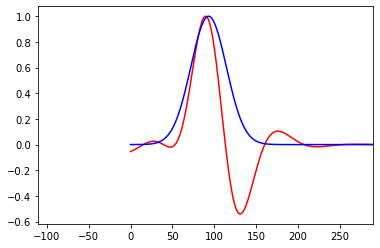

In [11]:
plt.plot(y/np.max(y),'r')
plt.plot(rs/np.max(rs),'b')
#plt.plot(z)
plt.xlim([maxpos-200,maxpos+200])

In [12]:
# activation function
def A(x,theta):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

In [13]:
# activation function
def nA(x,theta=42):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= 1
    return(y)

(-10, 190)

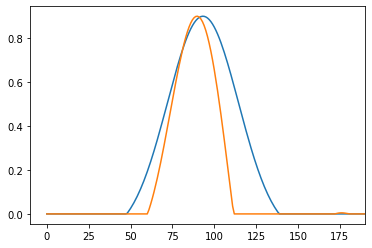

In [14]:
# shown with activatin function
rrs = rs/np.max(rs)
yy = y/np.max(y)
plt.plot(A(rrs,0.1))
plt.plot(A(yy,0.1))
plt.xlim([maxpos-100,maxpos+100])

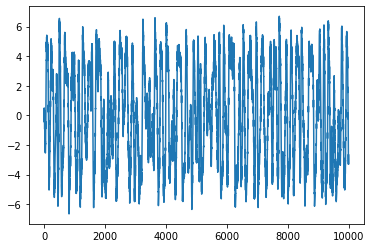

In [15]:
# difference between stimualtion and response peak
plt.plot(rpeak-speak)

#plt.ylim([0,15])
#plt.xlim([350,450])

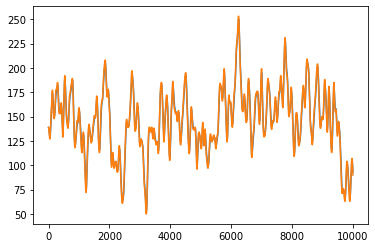

In [16]:
plt.plot(speak)
plt.plot(rpeak)

In [17]:
dms = range(-49,50)
mi_ss = [mi_quick(speak,speak,d) for d in dms]
mi_sr = [mi_quick(speak,rpeak,d) for d in dms]


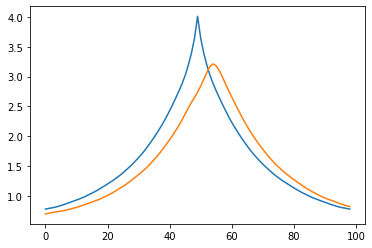

In [18]:
plt.plot(mi_ss)
plt.plot(mi_sr)

In [19]:
index = 100
yy = np.zeros(nstep)
for i in range(nstep):
    yy[i] = rsp[i][index]

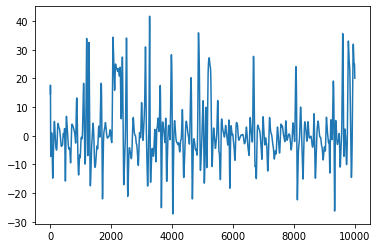

In [20]:
plt.plot(yy)

In [32]:
dms = range(-49,50)
mi_ss = [mi_quick(speak,speak,d) for d in dms]
mi_sr = [mi_quick(speak,rpeak,d) for d in dms]
mi_syy = [mi_quick(speak,nA(yy,20),d) for d in dms]

(0, 5)

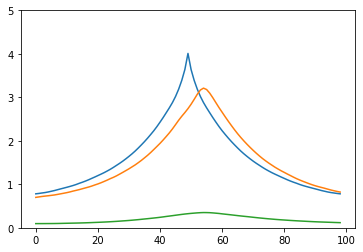

In [33]:
plt.plot(mi_ss)
plt.plot(mi_sr)
plt.plot(np.array(mi_syy))
plt.ylim([0,5])

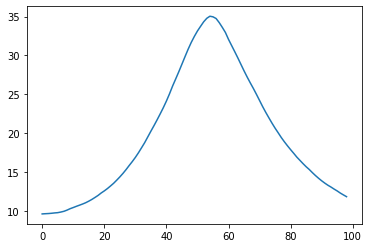

In [34]:
plt.plot(np.array(mi_syy)/dt)

In [35]:
sorty = np.sort(yy)
sorty[int(len(sorty)*0.9)]

16.053889755947843

In [36]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [37]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [38]:
#assign states
x = speak.copy()
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
v = ndimage.gaussian_filter1d(x.copy(), sigma=1, order=1, mode='wrap') / dt
xstate, _= EqualState(x, 6)
vstate, _= EqualState(v, 6)

In [42]:
window = [-1,1] # second
timeshift, Information = PIfunc(nA(yy,30), xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

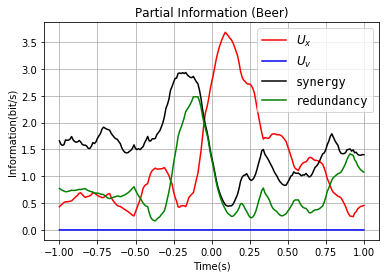

In [43]:
plt.plot(timeshift,Information[('Beer','UIx')], 'r-')
plt.plot(timeshift,Information[('Beer','UIv')], 'b-')
plt.plot(timeshift,Information[('Beer','Syn')], 'k-')
plt.plot(timeshift,Information[('Beer','Red')], 'g-')
plt.title('Partial Information (Beer)')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.grid()

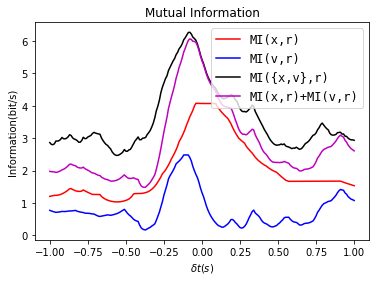

In [44]:
MIx = Information[('Beer','UIx')]+Information[('Beer','Red')]
MIv = Information[('Beer','UIv')]+Information[('Beer','Red')]
MIjoint = Information[('Beer','UIx')]+Information[('Beer','Syn')]+Information[('Beer','UIv')]+Information[('Beer','Red')]

#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')
plt.title('Mutual Information')
plt.xlabel(r'$\delta t(s)$')
plt.ylabel('Information(bit/s)')
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [45]:
sum(nA(yy))/len(nA(yy))

0.0